In [1]:
from gensim.models.keyedvectors import KeyedVectors
import numpy as np

import codecs
import argparse
import csv
import random

from collections import defaultdict

# very useful feature used to reload python modules
from importlib import reload

# import module that loads data, tokenises the tuples, initialises the embeddings matrix
import crim_data

import multiprojection_model
import yamane_model
# contains code to evaluate according to semeval2018 metrics
import semeval_eval
import crim_evaluator
import yamane_evaluator

from sklearn.model_selection import KFold

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

In [2]:
# initialise embeddings and normalise to unit-norm
#model = KeyedVectors.load_word2vec_format('embeddings/GoogleNews-vectors-negative300.bin', binary=True)
#model = KeyedVectors.load_word2vec_format('embeddings/glove.42B.300d.txt', binary=False)
model = KeyedVectors.load_word2vec_format('embeddings/wiki-news-300d-1M.vec', binary=False)

#model.save_word2vec_format('embeddings/GoogleNews-vectors-negative300.txt', binary=False)
model.init_sims(replace=True)

In [3]:
# import Ustalov et al. prepare module
import prepare

sub_train = prepare.read_subsumptions('subsumptions-train.txt')
sub_test = prepare.read_subsumptions('subsumptions-test.txt')
sub_validation = prepare.read_subsumptions('subsumptions-validation.txt')


# remove vocab term having no vector in embeddings
def get_terms_having_vectors(w2v, dataset):
    return [(q,h) for q, h in dataset if q in w2v and h in w2v]

sub_train = get_terms_having_vectors(model, sub_train)
sub_test = get_terms_having_vectors(model, sub_test)
sub_validation = get_terms_having_vectors(model, sub_validation)


# create hypernym dictionary
hyper_dict = defaultdict(list)
for x, y in sub_train + sub_test + sub_validation:        
    hyper_dict[x].append(y)
    
hyper_dict.default_factory = None

# to ensure that synonyms are not also hypernyms
synonyms = prepare.read_synonyms('synonyms.txt', hyper_dict)  
synonyms = prepare.get_synonymys_having_vectors(synonyms, model)
synonyms.default_factory = None


print ("Total number of tuples in entire set: %d" % (len([x for (x,y) in sub_train + sub_test + sub_validation])))
print ("Unique hyponyms in set: %d" % (len(set([x for (x,y) in sub_train + sub_test + sub_validation]))))

Total number of tuples in entire set: 7377
Unique hyponyms in set: 2247


In [4]:
args = {'w2v':model,
        'train':sub_train, 'test':sub_test, 'validation':sub_validation, 'synonyms':synonyms, 
        'limited_vocab_n': 250000
       }
data = crim_data.CrimData(args)

Creating limited vocabulary of 250000
Dataset vocabulary size is 3198
Truncated vocab length is 250000
Vocab size is 250000 words
Initialising negative sampler
Tokenising all dataset tuples
Creating embeddings matrix
Done!


In [10]:
# convert full dataset to array
all_data_tokens = np.asarray(data.all_data_token)

kf = KFold(n_splits=5, random_state=42)
kf.get_n_splits(all_data_tokens[:,0])

# split data into 5 different train-test folds
train_data_split = []
test_data_split = []
for k in kf.split(all_data_tokens[:,0]):    
    k_train_split = all_data_tokens[k[0]]
    k_test_split = all_data_tokens[k[1]]
    
    train_data_split.append(k_train_split)
    test_data_split.append(k_test_split)

# output training-test split sizes    
for tr, te in zip(train_data_split, test_data_split):
    print ("Training tuples: %d; test tuples: %d" % (len(tr), len(te)))

Training tuples: 5901; test tuples: 1476
Training tuples: 5901; test tuples: 1476
Training tuples: 5902; test tuples: 1475
Training tuples: 5902; test tuples: 1475
Training tuples: 5902; test tuples: 1475


In [44]:
# create random split
from itertools import count
from random import shuffle

def hash_word(s):
    """
    Decide for which set to assign this word, such that most words will
    be assigned to the train set, then to the test set and the least words will
    be assigned to the validation set
    :param s:
    :return:
    """
    f = s % 14
    if f < 11:
        return 0
    else:
        return 1

def get_lexical_split(sub_train, sub_test, sub_validation):
    vocab = set([x for (x,y) in sub_train + sub_test + sub_validation])
    counter = count()
    lex_dict = defaultdict(lambda x=count(0): next(x))
    input_data = sub_train + sub_test + sub_validation
    [lex_dict[w] for w in vocab]

    lex = [[], []]
    lex_mixed = []

    for x, y  in input_data:
        hash_x = hash_word(lex_dict[x])
        hash_y = hash_word(lex_dict[y])
        if hash_x == hash_y:
            lex[hash_x].append((x, y))
        else:
            lex_mixed.append((x, y))

    lex_train, lex_test = lex
    print ('Train:', len(lex_train), ', Test:', len(lex_test))
    return lex_train, lex_test

lex_train, lex_test = get_lexical_split(sub_train, sub_test, sub_validation)

# convert lexical split to tokens
lex_train = data.tokenizer.texts_to_sequences([[x,y] for x, y  in lex_train])
lex_test = data.tokenizer.texts_to_sequences([[x,y] for x, y  in lex_test])
# convert lists to arrays
lex_train = np.asarray(lex_train)
lex_test = np.asarray(lex_test)
# add lexically split dataset to list of datasets
train_data_split.append(lex_train)
test_data_split.append(lex_test)
#train_datasets.append(lex_train)
#test_datasets.append(lex_test)

Train: 4949 , Test: 236


In [ ]:
data.token_to_words()

In [7]:
def train_and_evaluate_1_fold(hyp_model, train_split, test_split):    
    
    # fit model
    # the test split is only used to measure the test loss
    hyp_model.fit(train_split, test_split)    
    # this step should not be required since the model is dynamically linked to the evaluator
    hyp_model.evaluator.set_model(hyp_model.model)
    # generates predictions according to trained model
    predictions = hyp_model.evaluator.predict(test_split)
    # this converts the tokens back to words for evaluation
    test_tuples = data.token_to_words(test_split)
    # here we have a scorer that will mark our effort according to this particular test split
    scorer = semeval_eval.HypernymEvaluation(test_tuples)
    # get scores
    score_names, all_scores = scorer.get_evaluation_scores(predictions)
    # initialise scores (MRR, MAP, ...)
    scores = {s:0.0 for s in score_names }
    for k in range(len(score_names)):    
        scores[score_names[k]] = float('%.5f' % (sum([score_list[k] for score_list in all_scores]) / len(all_scores)))    

    return scores
    

# MULTI-PROJECTION Section

In [177]:
embeddings_layer = multiprojection_model.get_embeddings_model(data.embeddings_matrix, 5)

In [185]:
from itertools import product

# standard model parameters - we won't be changing these
args['data']              = data
args['embeddings_layer']  = embeddings_layer
args['epochs']            = 15
args['batch_size']        = 32
args['synonym_sample_n']  = 5
args['phi_k']             = 10
args['lambda_c']          = 0.
args['negative_sample_n'] = 10
args['save_path']         = 'ft_multiproj.npz'
args['patience']          = 15
args['eval_after_epoch']  = False
args['lr']                = 0.001
args['beta1']             = 0.9
args['beta2']             = 0.9
args['clip_value']        = 1.

# generate parameter combinations
_clusters = [10, 5, 1]
#_clusters = [10]
_lambda_c = [0, 0.1, 1]
#_lambda_c = [1.]
_neg_count = [10, 5, 1]
#_neg_count = [10]

parameters = [_clusters, _lambda_c, _neg_count]

param_list = list(product(*parameters))

# initialise hypernymy discovery model which we will reuse by resetting the model with new args
hyp_model = multiprojection_model.MultiProjModel(args)



In [62]:
# initialise final_scores dictionary
final_scores = {k:defaultdict(list) for k in param_list}

for idx2, _param in enumerate(param_list):
    print ("Running test with following parameters: phi_k: %d; lambda_c: %0.2f; neg_count: %d" \
           % (_param[0], _param[1], _param[2]))

    args['phi_k'] = _param[0]
    args['lambda_c'] = _param[1]
    args['negative_sample_n'] = _param[2]    
    
    # iterate over every split to get score distribution
    for idx, td in enumerate(train_data_split[5:]):              
        hyp_model.reset_model(args=args)
        
        scores = train_and_evaluate_1_fold(hyp_model, td, test_data_split[5])
        for s, v  in scores.items():
            final_scores[_param][s].append(v)
    print ("")
    print ("Finished %d from %d experiments" % (idx2+1, len(param_list)))
    print ("-"*30)

Running test with following parameters: phi_k: 10; lambda_c: 0.00; neg_count: 10
Fitting model with following parameters:
 batch_size=32;
 phi_k=10;
 lambda_c=0.00;
 epochs=15;
 negative_count=10;
 synonym_count=5
Optimizer parameters:
 lr=0.00100;
 beta1=0.900;
 beta2=0.900;
 clip=1.00
--------------------
Epoch: 1; Training Loss: 0.53018; Test Loss: 0.33940; Test MAP: 0.00000; Test MRR: 0.00000
Epoch: 2; Training Loss: 0.36812; Test Loss: 0.23014; Test MAP: 0.00000; Test MRR: 0.00000
Epoch: 3; Training Loss: 0.27957; Test Loss: 0.17256; Test MAP: 0.00000; Test MRR: 0.00000
Epoch: 4; Training Loss: 0.22141; Test Loss: 0.13400; Test MAP: 0.00000; Test MRR: 0.00000
Epoch: 5; Training Loss: 0.17854; Test Loss: 0.11252; Test MAP: 0.00000; Test MRR: 0.00000
Epoch: 6; Training Loss: 0.14737; Test Loss: 0.09122; Test MAP: 0.00000; Test MRR: 0.00000
Epoch: 7; Training Loss: 0.12320; Test Loss: 0.07672; Test MAP: 0.00000; Test MRR: 0.00000
Epoch: 8; Training Loss: 0.10451; Test Loss: 0.06866; 

Epoch: 11; Training Loss: 0.08024; Test Loss: 0.06526; Test MAP: 0.00000; Test MRR: 0.00000
Epoch: 12; Training Loss: 0.07102; Test Loss: 0.05955; Test MAP: 0.00000; Test MRR: 0.00000
Epoch: 13; Training Loss: 0.06304; Test Loss: 0.05877; Test MAP: 0.00000; Test MRR: 0.00000
Epoch: 14; Training Loss: 0.05678; Test Loss: 0.06372; Test MAP: 0.00000; Test MRR: 0.00000
Epoch: 15; Training Loss: 0.05100; Test Loss: 0.04732; Test MAP: 0.00000; Test MRR: 0.00000
Done!
Done 100

Finished 5 from 27 experiments
------------------------------
Running test with following parameters: phi_k: 10; lambda_c: 0.10; neg_count: 1
Fitting model with following parameters:
 batch_size=32;
 phi_k=10;
 lambda_c=0.10;
 epochs=15;
 negative_count=1;
 synonym_count=5
Optimizer parameters:
 lr=0.00100;
 beta1=0.900;
 beta2=0.900;
 clip=1.00
--------------------
Epoch: 1; Training Loss: 0.59286; Test Loss: 0.49843; Test MAP: 0.00000; Test MRR: 0.00000
Epoch: 2; Training Loss: 0.46822; Test Loss: 0.36447; Test MAP: 

Epoch: 5; Training Loss: 0.26921; Test Loss: 0.19032; Test MAP: 0.00000; Test MRR: 0.00000
Epoch: 6; Training Loss: 0.23358; Test Loss: 0.16161; Test MAP: 0.00000; Test MRR: 0.00000
Epoch: 7; Training Loss: 0.20221; Test Loss: 0.14471; Test MAP: 0.00000; Test MRR: 0.00000
Epoch: 8; Training Loss: 0.17916; Test Loss: 0.12875; Test MAP: 0.00000; Test MRR: 0.00000
Epoch: 9; Training Loss: 0.15672; Test Loss: 0.11309; Test MAP: 0.00000; Test MRR: 0.00000
Epoch: 10; Training Loss: 0.13869; Test Loss: 0.10158; Test MAP: 0.00000; Test MRR: 0.00000
Epoch: 11; Training Loss: 0.12432; Test Loss: 0.09204; Test MAP: 0.00000; Test MRR: 0.00000
Epoch: 12; Training Loss: 0.11102; Test Loss: 0.08343; Test MAP: 0.00000; Test MRR: 0.00000
Epoch: 13; Training Loss: 0.09955; Test Loss: 0.07600; Test MAP: 0.00000; Test MRR: 0.00000
Epoch: 14; Training Loss: 0.08857; Test Loss: 0.06976; Test MAP: 0.00000; Test MRR: 0.00000
Epoch: 15; Training Loss: 0.08089; Test Loss: 0.06645; Test MAP: 0.00000; Test MRR: 0

Epoch: 1; Training Loss: 0.64916; Test Loss: 0.59863; Test MAP: 0.00000; Test MRR: 0.00000
Epoch: 2; Training Loss: 0.57677; Test Loss: 0.51986; Test MAP: 0.00000; Test MRR: 0.00000
Epoch: 3; Training Loss: 0.51027; Test Loss: 0.44723; Test MAP: 0.00000; Test MRR: 0.00000
Epoch: 4; Training Loss: 0.45364; Test Loss: 0.38959; Test MAP: 0.00000; Test MRR: 0.00000
Epoch: 5; Training Loss: 0.40198; Test Loss: 0.33509; Test MAP: 0.00000; Test MRR: 0.00000
Epoch: 6; Training Loss: 0.35640; Test Loss: 0.29004; Test MAP: 0.00000; Test MRR: 0.00000
Epoch: 7; Training Loss: 0.31538; Test Loss: 0.26082; Test MAP: 0.00000; Test MRR: 0.00000
Epoch: 8; Training Loss: 0.28162; Test Loss: 0.22922; Test MAP: 0.00000; Test MRR: 0.00000
Epoch: 9; Training Loss: 0.24999; Test Loss: 0.21213; Test MAP: 0.00000; Test MRR: 0.00000
Epoch: 10; Training Loss: 0.22585; Test Loss: 0.18534; Test MAP: 0.00000; Test MRR: 0.00000
Epoch: 11; Training Loss: 0.20013; Test Loss: 0.15562; Test MAP: 0.00000; Test MRR: 0.000

Epoch: 14; Training Loss: 0.23765; Test Loss: 0.22178; Test MAP: 0.00000; Test MRR: 0.00000
Epoch: 15; Training Loss: 0.23089; Test Loss: 0.21733; Test MAP: 0.00000; Test MRR: 0.00000
Done!
Done 100

Finished 19 from 27 experiments
------------------------------
Running test with following parameters: phi_k: 1; lambda_c: 0.00; neg_count: 5
Fitting model with following parameters:
 batch_size=32;
 phi_k=1;
 lambda_c=0.00;
 epochs=15;
 negative_count=5;
 synonym_count=5
Optimizer parameters:
 lr=0.00100;
 beta1=0.900;
 beta2=0.900;
 clip=1.00
--------------------
Epoch: 1; Training Loss: 0.66026; Test Loss: 0.61953; Test MAP: 0.00000; Test MRR: 0.00000
Epoch: 2; Training Loss: 0.59951; Test Loss: 0.55649; Test MAP: 0.00000; Test MRR: 0.00000
Epoch: 3; Training Loss: 0.54780; Test Loss: 0.50532; Test MAP: 0.00000; Test MRR: 0.00000
Epoch: 4; Training Loss: 0.50499; Test Loss: 0.46639; Test MAP: 0.00000; Test MRR: 0.00000
Epoch: 5; Training Loss: 0.46936; Test Loss: 0.43239; Test MAP: 0.00

Epoch: 8; Training Loss: 0.58603; Test Loss: 0.56743; Test MAP: 0.00000; Test MRR: 0.00000
Epoch: 9; Training Loss: 0.57163; Test Loss: 0.55094; Test MAP: 0.00000; Test MRR: 0.00000
Epoch: 10; Training Loss: 0.55762; Test Loss: 0.53417; Test MAP: 0.00000; Test MRR: 0.00000
Epoch: 11; Training Loss: 0.54569; Test Loss: 0.51928; Test MAP: 0.00000; Test MRR: 0.00000
Epoch: 12; Training Loss: 0.53244; Test Loss: 0.50744; Test MAP: 0.00000; Test MRR: 0.00000
Epoch: 13; Training Loss: 0.51955; Test Loss: 0.49066; Test MAP: 0.00000; Test MRR: 0.00000
Epoch: 14; Training Loss: 0.50711; Test Loss: 0.47978; Test MAP: 0.00000; Test MRR: 0.00000
Epoch: 15; Training Loss: 0.49644; Test Loss: 0.46584; Test MAP: 0.00000; Test MRR: 0.00000
Done!
Done 100

Finished 24 from 27 experiments
------------------------------
Running test with following parameters: phi_k: 1; lambda_c: 1.00; neg_count: 10
Fitting model with following parameters:
 batch_size=32;
 phi_k=1;
 lambda_c=1.00;
 epochs=15;
 negative_co

In [63]:
final_scores

{(10, 0, 10): defaultdict(list,
             {'MRR': [0.01765],
              'MAP': [0.01444],
              'P@1': [0.0],
              'P@5': [0.0152],
              'P@10': [0.0152]}),
 (10, 0, 5): defaultdict(list,
             {'MRR': [0.01765],
              'MAP': [0.01209],
              'P@1': [0.00588],
              'P@5': [0.01225],
              'P@10': [0.01225]}),
 (10, 0, 1): defaultdict(list,
             {'MRR': [0.01471],
              'MAP': [0.01046],
              'P@1': [0.00588],
              'P@5': [0.01078],
              'P@10': [0.01078]}),
 (10, 0.1, 10): defaultdict(list,
             {'MRR': [0.01961],
              'MAP': [0.01333],
              'P@1': [0.00588],
              'P@5': [0.01373],
              'P@10': [0.01373]}),
 (10, 0.1, 5): defaultdict(list,
             {'MRR': [0.02206],
              'MAP': [0.02039],
              'P@1': [0.00588],
              'P@5': [0.02157],
              'P@10': [0.02157]}),
 (10, 0.1, 1): defaultdict(lis

In [66]:
for k, v in final_scores.items():    
    cl_size = k[0]
    lam = k[1]
    neg = k[2]
    for k2, v2 in v.items():        
        print ("%d,%0.1f,%d,%s,%0.5f,%0.5f,%0.5f,%0.5f,%0.5f" 
               % (cl_size, lam, neg, k2, v2[0], v2[1], v2[2], v2[3], v2[4]) )
    

10,0.0,10,MRR,0.01765
10,0.0,10,MAP,0.01444
10,0.0,10,P@1,0.00000
10,0.0,10,P@5,0.01520
10,0.0,10,P@10,0.01520
10,0.0,5,MRR,0.01765
10,0.0,5,MAP,0.01209
10,0.0,5,P@1,0.00588
10,0.0,5,P@5,0.01225
10,0.0,5,P@10,0.01225
10,0.0,1,MRR,0.01471
10,0.0,1,MAP,0.01046
10,0.0,1,P@1,0.00588
10,0.0,1,P@5,0.01078
10,0.0,1,P@10,0.01078
10,0.1,10,MRR,0.01961
10,0.1,10,MAP,0.01333
10,0.1,10,P@1,0.00588
10,0.1,10,P@5,0.01373
10,0.1,10,P@10,0.01373
10,0.1,5,MRR,0.02206
10,0.1,5,MAP,0.02039
10,0.1,5,P@1,0.00588
10,0.1,5,P@5,0.02157
10,0.1,5,P@10,0.02157
10,0.1,1,MRR,0.02059
10,0.1,1,MAP,0.01353
10,0.1,1,P@1,0.00588
10,0.1,1,P@5,0.01373
10,0.1,1,P@10,0.01373
10,1.0,10,MRR,0.01961
10,1.0,10,MAP,0.01725
10,1.0,10,P@1,0.00588
10,1.0,10,P@5,0.01814
10,1.0,10,P@10,0.01814
10,1.0,5,MRR,0.01961
10,1.0,5,MAP,0.01569
10,1.0,5,P@1,0.00000
10,1.0,5,P@5,0.01667
10,1.0,5,P@10,0.01667
10,1.0,1,MRR,0.01912
10,1.0,1,MAP,0.01451
10,1.0,1,P@1,0.00588
10,1.0,1,P@5,0.01520
10,1.0,1,P@10,0.01520
5,0.0,10,MRR,0.00882
5,0.0,10,M

In [ ]:
score_freq = get_score_freq_matrix(test_data_split[4], predictions_2, hyper_freq)

# YAMANE Section

In [5]:
def yam_train_and_evaluate_1_fold(yam, train_split, test_split):    
    
    # fit model
    # the test split is only used to measure the test loss
    yam.fit(train_split, test_split)    
    # this step should not be required since the model is dynamically linked to the evaluator
    yam.evaluator.set_ensemble(yam)
    # generates predictions according to trained model
    predictions = yam.evaluator.predict(test_split)
    # this converts the tokens back to words for evaluation
    test_tuples = data.token_to_words(test_split)
    # here we have a scorer that will mark our effort according to this particular test split
    scorer = semeval_eval.HypernymEvaluation(test_tuples)
    # get scores
    score_names, all_scores = scorer.get_evaluation_scores(predictions)
    # initialise scores (MRR, MAP, ...)
    scores = {s:0.0 for s in score_names }
    for k in range(len(score_names)):    
        scores[score_names[k]] = float('%.5f' % (sum([score_list[k] for score_list in all_scores]) / len(all_scores)))    

    return scores
    

In [6]:
embeddings_layer2 = yamane_model.get_embeddings_model(data.embeddings_matrix)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Colocations handled automatically by placer.


In [7]:
from itertools import product

# initialise Yamane Model
args={'data':data, 
      'embeddings_layer': embeddings_layer2, 
      'lr':0.001,'lambda_c':0.18, 
      'negative_sample_n':5, 
      'epochs':10, 
      'save_path':'ft_yamane_016.npz', 
      'eval_after_epoch':True,
      'patience':2}

# generate parameter combinations
_lambda_c = [0.18]
_neg_count = [5]

parameters = [_lambda_c, _neg_count]
param_list = list(product(*parameters))

yummy = yamane_model.YamaneEnsemble(args)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [85]:
# initialise final_scores dictionary
final_scores = {k:defaultdict(list) for k in param_list}

for idx2, _param in enumerate(param_list):
    print ("Running test with following parameters: lambda_c: %0.2f; neg_count: %d" \
           % (_param[0], _param[1]))
    
    args['lambda_c'] = _param[0]
    args['negative_sample_n'] = _param[1]    
    
    # iterate over every split to get score distribution
    for idx, td in enumerate(train_data_split[2:3]):              
        yummy.reset_ensemble(args=args)
        
        scores = yam_train_and_evaluate_1_fold(yummy, td, test_data_split[2])
        for s, v  in scores.items():
            final_scores[_param][s].append(v)
    print ("")
    print ("Finished %d from %d experiments" % (idx2+1, len(param_list)))
    print ("-"*30)

Running test with following parameters: lambda_c: 0.18; neg_count: 5
Fitting model with following parameters:
 lambda_c=0.18;
 epochs=25;
 negative_count=5;
 lr=0.00100;
 eval_after_epoch:False
Processed  1000 samples...
Processed  2000 samples...
Processed  3000 samples...
Processed  4000 samples...
Processed  5000 samples...
Epoch: 1; Clusters: 2; Training Loss: 0.34616; Test Loss: 0.27037; Test MAP: 0.00000; Test MRR: 0.00000
Processed  1000 samples...
Processed  2000 samples...
Processed  3000 samples...
Processed  4000 samples...
Processed  5000 samples...
Epoch: 2; Clusters: 2; Training Loss: 0.21236; Test Loss: 0.19824; Test MAP: 0.00000; Test MRR: 0.00000
Processed  1000 samples...
Processed  2000 samples...
Processed  3000 samples...
Processed  4000 samples...
Processed  5000 samples...
Epoch: 3; Clusters: 2; Training Loss: 0.15488; Test Loss: 0.15313; Test MAP: 0.00000; Test MRR: 0.00000
Processed  1000 samples...
Processed  2000 samples...
Processed  3000 samples...
Processe

In [86]:
yummy.sample_clusters
Counter(yummy.sample_clusters)

Counter({0: 5638, 1: 264})

In [ ]:
final_scores
# nicer output of final scores
for k, v in final_scores.items():    
    lam = k[0]
    neg = k[1]
    for k2, v2 in v.items():        
        print ("%0.2f,%d,%s,%0.5f,%0.5f,%0.5f,%0.5f,%0.5f" % (lam, neg, k2, v2[0], v2[1], v2[2], v2[3], v2[4]) )

# get mean scores        
for v in final_scores.values():
    for k, v2 in v.items():
        print ("%s: %0.5f" % (k, np.mean(v2)))

In [ ]:
# peek into the one of the clusters
with open("demofile.txt", "a") as f:
    for c in range(len(Counter(yummy.sample_clusters))):
        #print ("Cluster %d" % (c))
        for idx, i in enumerate(np.where(yummy.sample_clusters == c)[0]):
            s4_hypo = data.tokenizer.index_word[ train_data_split[4][i][0]]
            s4_hyper = data.tokenizer.index_word[ train_data_split[4][i][1]]

            f.write ("%d,%s,%s\n" % (c,s4_hypo,s4_hyper))            


In [ ]:
# get hypernym representation by total in cluster
def get_hypernym_rep_in_cluster(fold, clusters, c, top_running_perc):
    hyper_freq = list(map(lambda w:data.tokenizer.index_word[w], fold[:,1][np.where(clusters == c)]))
    # group hypernyms and count instances
    hyper_freq = Counter(hyper_freq)
    total_pairs = sum(hyper_freq.values())    
    total_uniq_hypers = len(hyper_freq.keys())
    
    running_total = 0.
    result = []
    for count, word in sorted(((value, key) for (key,value) in hyper_freq.items()), reverse = True):                
        perc_total = round(count / (1. * total_pairs), 5)
        running_total += perc_total        
        result.append((word, count, total_uniq_hypers, perc_total))        
        if running_total > top_running_perc:
            break
    return result

for c in range(len(Counter(yummy.sample_clusters))):
    print ("Cluster %d" % (c))
    for word, pairs, tot, perc_pairs in get_hypernym_rep_in_cluster(train_data_split[4], yummy.sample_clusters, c, 0.4):
        print ("%s,%d,%d,%0.5f" % (word, pairs, tot, perc_pairs))
    print ("-"*30)

# Analysis of Prediction quality vs hypernym freq in training set

In [193]:
# perform freq analysis of all hypernyms in training set; query terms will not features in test but test terms
# will certainly be related to hypernyms found in training set.
def get_hypernym_freq(dataset):
    all_hypernyms = Counter([y for x, y in data.token_to_words(dataset)])
    cnt_distinct_hyper = sum(all_hypernyms.values())
    #sorted([(y, x) for x, y in all_hypernyms.items()], reverse=True)
    hyper_freq = {w:round((cnt/cnt_distinct_hyper), 5) for w, cnt in all_hypernyms.items()}
    return hyper_freq

In [165]:
np.sum(list(hyper_freq.values()))

1.0011100000000002

In [48]:
predictions = yummy.evaluator.predict(test_data_split[4])

Done 100
Done 200
Done 300
Done 400


In [50]:
# we score as per the usual way the predictions
test_tuples = data.token_to_words(test_data_split[4])
scorer = semeval_eval.HypernymEvaluation(test_tuples)
# get scores
score_names, all_scores = scorer.get_evaluation_scores(predictions)
# initialise scores (MRR, MAP, ...)
scores = {s:0.0 for s in score_names }
for k in range(len(score_names)):    
    scores[score_names[k]] = float('%.5f' % (sum([score_list[k] for score_list in all_scores]) / len(all_scores)))    
    
# we create a dictionary of ground truth hypernyms for the test split of interest    
ground_truth = defaultdict(list)
for x, y in test_tuples:
    ground_truth[x].append(y)
ground_truth.default_factory = None    

In [394]:
def get_score_freq_matrix(test_data, predictions, hyper_freq, jitter=False):
    # we score as per the usual way the predictions
    test_tuples = data.token_to_words(test_data)
    scorer = semeval_eval.HypernymEvaluation(test_tuples)
    # get scores
    score_names, all_scores = scorer.get_evaluation_scores(predictions)
    # initialise scores (MRR, MAP, ...)
    scores = {s:0.0 for s in score_names }
    for k in range(len(score_names)):    
        scores[score_names[k]] = float('%.5f' % (sum([score_list[k] for score_list in all_scores]) / len(all_scores)))    

    # we create a dictionary of ground truth hypernyms for the test split of interest    
    ground_truth = defaultdict(list)
    for x, y in test_tuples:
        ground_truth[x].append(y)
    ground_truth.default_factory = None    


    # retain MAP scores only from score list of lists
    all_map = np.round(np.asarray(all_scores)[:,1], 3)

    # iterate over every query term in test set; create dataset with AP score for word, median freq of ground
    # truth hypernym, based on appearance in training set.  Hypernyms that did not appear at all, will be assigned
    # freq of 0.
    score_freq_matrix = np.zeros((all_map.shape[0], 2))
    # sort prediction keys explicityly to make sure we process in the same order processed by evaluator
    for idx, w in enumerate(sorted(predictions.keys())):
        # find freq of predictions
        score_freq_matrix[idx][0] = all_map[idx]
        gold = ground_truth[w]
        score_freq_matrix[idx][1] = np.median(([hyper_freq[g] if g in hyper_freq else 0. for g in gold]))
        
    if jitter:
        # add some jitter to the signal to make it easier to interpret in the scatterplot
        mu, sigma = 0, 0.01 
        # creating a noise with the same dimension as the dataset (2,2) 
        noise = np.random.normal(mu, sigma, (all_map.shape[0], 2) )
        score_freq_matrix =  score_freq_matrix + noise

    score_freq = pd.DataFrame(score_freq_matrix, columns=['AP', 'Median Freq'])
    # add query word to data frame
    score_freq = score_freq.assign(word=pd.Series(list(predictions.keys())).values)
    return score_freq

In [395]:
# prediction contains the generated hypernyms for YAMANE on the 5th fold of the training_data
score_freq_yam=get_score_freq_matrix(test_data_split[4], predictions, hyper_freq)

# prediction_2 contains the generated hypernyms for CRIM on the 5th fold of the training data
score_freq=get_score_freq_matrix(test_data_split[4], predictions_2, hyper_freq)


#score_freq.loc[score_freq.MAP == 1.,].sort_values('Median Freq', ascending=False)

[(-0.05, 1.05)]

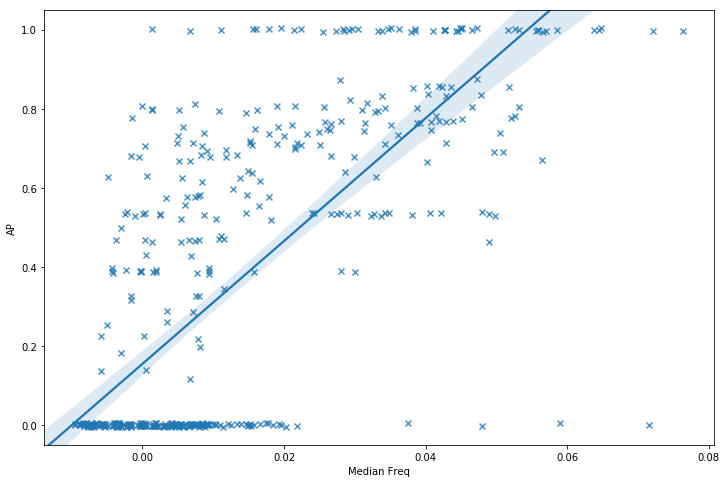

In [401]:
#sns.relplot(x="Median Freq", y="MAP", data=score_freq);
plt.figure(figsize=(12,8))
ax = sns.regplot(x="Median Freq", y="AP", data=score_freq_yam, x_jitter=0.01, y_jitter=0.005, marker="x");
ax.set(ylim=(-0.05, 1.05))

[(-0.05, 1.05)]

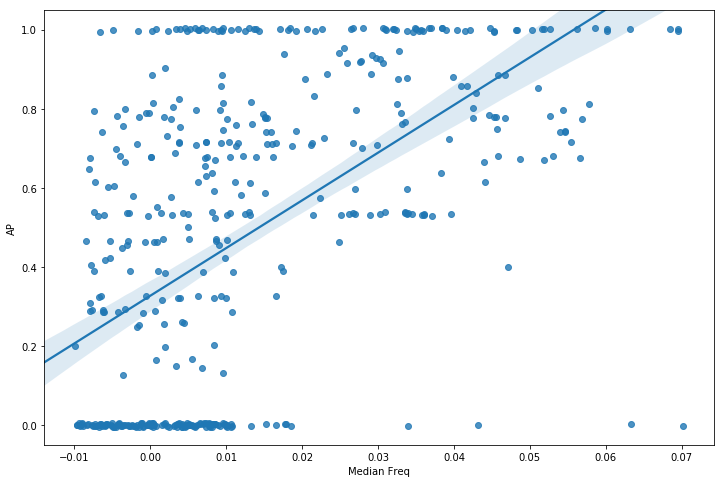

In [398]:
plt.figure(figsize=(12,8))
ax = sns.regplot(x="Median Freq", y="AP", data=score_freq, x_jitter=0.01, y_jitter=0.005);
ax.set(ylim=(-0.05, 1.05))


In [383]:
top_yummy_wrong

[(38, 'kind'),
 (22, 'move'),
 (21, 'animal'),
 (15, 'feeling'),
 (14, 'artifact'),
 (13, 'nature'),
 (12, 'plant'),
 (10, 'artefact'),
 (9, 'vertebrate'),
 (8, 'make'),
 (7, 'approach'),
 (5, 'vehicle'),
 (3, 'create'),
 (2, 'step'),
 (2, 'recognize')]

In [261]:
# analyze top-ranked word for term words scoring 0 MAP
yummy_wrong_terms = score_freq_yam.loc[score_freq_yam.MAP==0, 'word'].tolist()
crim_wrong_terms  = score_freq.loc[score_freq.MAP==0, 'word'].tolist()

top_crim_wrong = []
top_yummy_wrong = []

for w in crim_wrong_terms:
    top_crim_wrong.append(predictions_2[w][0])
    
for w in yummy_wrong_terms:
    top_yummy_wrong.append(predictions[w][0])    
    
top_crim_wrong =  sorted([(v,k) for k, v in Counter(top_crim_wrong).items()], reverse=True)[:15]
top_yummy_wrong =  sorted([(v,k) for k, v in Counter(top_yummy_wrong).items()], reverse=True)[:15]

# multiply words according to frequency
yummy_wrong_flat = [li for lol in list(map(lambda w: [w[1]] * w[0], top_yummy_wrong)) for li in lol  ]
crim_wrong_flat = [li for lol in list(map(lambda w: [w[1]] * w[0], top_crim_wrong)) for li in lol  ]

combined_wrong_list = list(zip(['CRIM'] * len(crim_wrong_flat), crim_wrong_flat))
combined_wrong_list.extend(list(zip(['Yamane'] * len(yummy_wrong_flat), yummy_wrong_flat)))

In [331]:
incorrect_df =  pd.DataFrame(combined_wrong_list, columns=['Model', 'Highest Ranked Incorrect Word'])

In [335]:
incorrect_df.loc[incorrect_df.Model == 'CRIM',]

,Model,Highest Ranked Incorrect Word
0,CRIM,animal
1,CRIM,animal
2,CRIM,animal
3,CRIM,animal
4,CRIM,animal
5,CRIM,animal
6,CRIM,animal
7,CRIM,animal
8,CRIM,animal
9,CRIM,animal


[Text(0, 0, 'animal'),
 Text(0, 0, 'place'),
 Text(0, 0, 'wear'),
 Text(0, 0, 'object'),
 Text(0, 0, 'feeling'),
 Text(0, 0, 'shape'),
 Text(0, 0, 'relationship'),
 Text(0, 0, 'mammal'),
 Text(0, 0, 'kind'),
 Text(0, 0, 'implement'),
 Text(0, 0, 'identify'),
 Text(0, 0, 'determine'),
 Text(0, 0, 'clothing'),
 Text(0, 0, 'change'),
 Text(0, 0, 'vehicle')]

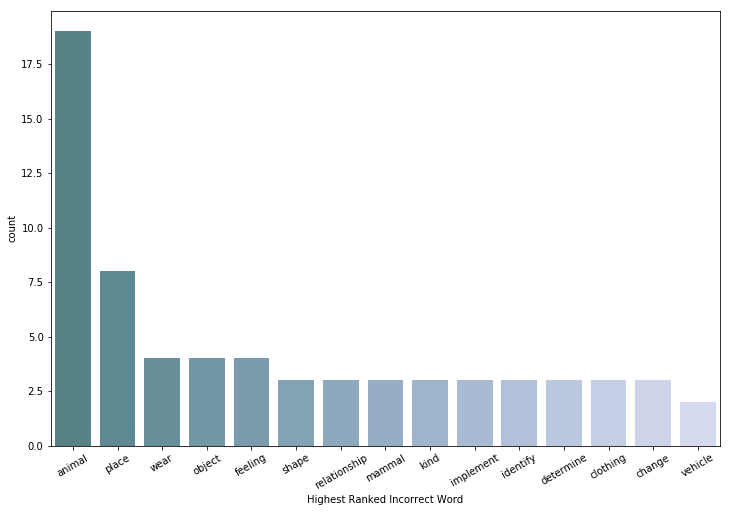

In [380]:
plt.figure(figsize=(12,8))
g = sns.countplot(x="Highest Ranked Incorrect Word", 
                  palette=sns.cubehelix_palette(15, start=2, rot=0.35, dark=0.47, light=0.85, reverse=True), 
                  data=incorrect_df.loc[incorrect_df.Model == 'CRIM',])
g.set_xticklabels(g.get_xticklabels(), rotation=30)

In [419]:
for w in sorted([(v, k)for k, v in hyper_freq.items()], reverse=True)[:10]:
    print (w[1], w[0])
    
hyper_freq['action']

animal 0.06676
plant 0.05947
chordate 0.04863
vertebrate 0.04812
mammal 0.02762
placental 0.02474
herb 0.0205
invertebrate 0.01305
artifact 0.01288
artefact 0.01288


0.00271

[Text(0, 0, 'kind'),
 Text(0, 0, 'move'),
 Text(0, 0, 'animal'),
 Text(0, 0, 'feeling'),
 Text(0, 0, 'artifact'),
 Text(0, 0, 'nature'),
 Text(0, 0, 'plant'),
 Text(0, 0, 'artefact'),
 Text(0, 0, 'vertebrate'),
 Text(0, 0, 'make'),
 Text(0, 0, 'approach'),
 Text(0, 0, 'vehicle'),
 Text(0, 0, 'create'),
 Text(0, 0, 'step'),
 Text(0, 0, 'recognize')]

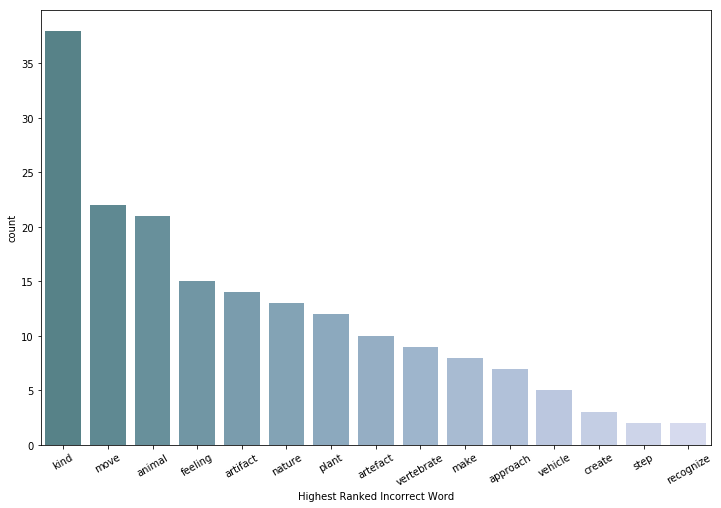

In [382]:
plt.figure(figsize=(12,8))
g = sns.countplot(x="Highest Ranked Incorrect Word", 
                  palette=sns.cubehelix_palette(15, start=2, rot=0.35, dark=0.47, light=0.85, reverse=True), 
                  data=incorrect_df.loc[incorrect_df.Model == 'Yamane',])
g.set_xticklabels(g.get_xticklabels(), rotation=30)

In [388]:
for w in sorted([(v, k)for k, v in hyper_freq.items()], reverse=True)[:10]:
    print (w[1], w[0])

animal 0.06676
plant 0.05947
chordate 0.04863
vertebrate 0.04812
mammal 0.02762
placental 0.02474
herb 0.0205
invertebrate 0.01305
artifact 0.01288
artefact 0.01288


In [393]:
# least frequent hypernyms
for w in [(v, k) for k, v in hyper_freq.items() if v == min(hyper_freq.values())][:10]:
    print (w[1], w[0])

attach 0.00017
property 0.00017
attitude 0.00017
enemy 0.00017
relationship 0.00017
aconite 0.00017
exist 0.00017
handcart 0.00017
educational 0.00017
helpful 0.00017


In [435]:
# let's see good scores low frequency
good_words = score_freq.loc[(score_freq.AP >= 1.0) & (score_freq['Median Freq'] < 0.005) , 'word'].tolist()
score_freq.loc[(score_freq.AP >= 1.0) & (score_freq['Median Freq'] < 0.005) , ]

,AP,Median Freq,word
6,1.0,0.00373,airship
61,1.0,0.00339,canoe
121,1.0,0.00271,drape
152,1.0,0.00085,fog
230,1.0,0.00017,liberty
376,1.0,0.00119,square
426,1.0,0.00271,violence
447,1.0,0.00237,yellow


In [439]:
for w in good_words:
    print ("%s: %s" % (w, ", ".join(predictions_2[w])))
    print ("%s: %s" % (w, ", ".join(hyper_dict[w])))
    print ("-"*30)
    
#print (hyper_dict['intercourse'])
#predictions_2['intercourse']


airship: vehicle, craft, aircraft, airplane, artifact, transport, plane, artefact, ship, transportation, spacecraft, vehicles, vessel, object, boat
airship: vehicle, craft, aircraft
------------------------------
canoe: vehicle, boat, craft, vessel, watercraft, transport, ship, transportation, canoe, artefact, artifact, animal, sport, mammal, container
canoe: boat, vessel, vehicle, craft
------------------------------
drape: cover, wear, buy, sell, protect, wrap, identify, represent, move, drape, construct, create, clothing, make, decorate
drape: cover
------------------------------
fog: weather, change, place, shape, supply, cover, transport, picture, affect, climate, light, matter, spot, condition, stay
fog: weather
------------------------------
liberty: freedom, liberty, belief, element, object, commitment, choice, property, relationship, understanding, support, place, gift, asset, idea
liberty: freedom
------------------------------
square: shape, place, form, figure, point, struc

# Fitting linear regression model on median freq , MAP data

In [402]:
from sklearn.linear_model import LinearRegression

slr = LinearRegression()
yummy_array =  score_freq_yam.loc[:,['Median Freq', 'AP']].values


slr.fit(yummy_array[:,0].reshape(-1,1), yummy_array[:,1])
print (slr.coef_[0], slr.intercept_)
print (slr.score(yummy_array[:,0].reshape(-1,1), yummy_array[:,1]))

15.538655576600439 0.15482195293469359
0.5066576766490934


In [403]:
crim_array =  score_freq.loc[:,['Median Freq', 'AP']].values


slr.fit(crim_array[:,0].reshape(-1,1), crim_array[:,1])
print (slr.coef_[0], slr.intercept_)
print (slr.score(crim_array[:,0].reshape(-1,1), crim_array[:,1]))

12.061517496075494 0.3269660086403724
0.305473899278386


# Scratch Pad

In [92]:
reload(crim_data)
reload(multiprojection_model)
reload(crim_evaluator)
reload(yamane_model)
reload(yamane_evaluator)

<module 'yamane_evaluator' from '/users/cborg/jfarrugia/hyperstar/yamane_evaluator.py'>

In [ ]:
predictions

In [ ]:
# get queries from tuples
#hyp_model.evaluator.predict_word('mare')
predictions = hyp_model.evaluator.predict(test_data_split[0])

In [ ]:
test_tuples = data.token_to_words(test_data_split[0])
scorer = semeval_eval.HypernymEvaluation(test_tuples)

# get scores
score_names, all_scores = scorer.get_evaluation_scores(predictions)

scores = {s:0.0 for s in score_names }

for k in range(len(score_names)):    
    scores[score_names[k]] = float('%.5f' % (sum([score_list[k] for score_list in all_scores]) / len(all_scores)))    

scores

In [ ]:
from itertools import product
# create score dictionary
_clusters = [1, 5, 10]
_lambda_c = [0, 0.1, 1]
_neg_count = [1, 5, 10]

parameters = [_clusters, _lambda_c, _neg_count]

param_list = list(product(*parameters))
final_scores = {k:defaultdict(list) for k in param_list}

In [ ]:
predictions = hyp_model.evaluator.predict(test_data_split[2])
test_tuples = data.token_to_words(test_data_split[2])
scorer = semeval_eval.HypernymEvaluation(test_tuples)
# get scores
score_names, all_scores = scorer.get_evaluation_scores(predictions)
# initialise scores (MRR, MAP, ...)
scores = {s:0.0 for s in score_names }
for k in range(len(score_names)):    
    scores[score_names[k]] = float('%.5f' % (sum([score_list[k] for score_list in all_scores]) / len(all_scores)))    

scores

In [ ]:
uniq_hypo = np.unique(all_data_tokens[:,0])
kf = KFold(n_splits=5, random_state=42)
kf.get_n_splits(uniq_hypo)

train_datasets = []
test_datasets = []
for idx, (train_index, test_index) in enumerate(kf.split(uniq_hypo)):
    #print len(train_index), len(test_index)    
    train_hyper_count = 0
    
    test_hyper_count = 0
    for i in train_index:
        train_hyper_count += len(data.hypernym_id_lookup[uniq_hypo[i]])
    for i in test_index:
        test_hyper_count += len(data.hypernym_id_lookup[uniq_hypo[i]])
    print (train_hyper_count, test_hyper_count)
        
    fold_set = []
    for i in train_index:
        for j in data.hypernym_id_lookup[uniq_hypo[i]]:
            fold_set.append((uniq_hypo[i], j))    
    train_datasets.append(np.asarray(fold_set))  
    
    fold_set = []
    for i in test_index:
        for j in data.hypernym_id_lookup[uniq_hypo[i]]:
            fold_set.append((uniq_hypo[i], j))    
    test_datasets.append(np.asarray(fold_set))


In [ ]:
predictions